# FCKG Simple Demo Notebook

This notebook intentionally stays minimal:

1. Load core RDF data (`movieontology.ttl` + `data/instances/*.ttl`)
2. Run a few local SPARQL queries
3. Show one API example each for TMDB, OMDb (using IMDb ID), and Wikidata


In [16]:
from pathlib import Path
import os
import json

import pandas as pd
import requests
from rdflib import Graph

# Match enrichment pipeline behavior: load keys from .env into environment
try:
    from dotenv import load_dotenv
    load_dotenv()  # loads .env
except Exception:
    pass

TMDB_API_KEY = os.getenv("TMDB_API_KEY", "")
OMDB_API_KEY = os.getenv("OMDB_API_KEY", "")

print(f"TMDB key configured: {bool(TMDB_API_KEY)}")
print(f"OMDb key configured: {bool(OMDB_API_KEY)}")


def normalize_tmdb_id(value):
    """Normalize TMDB IDs so numeric values never keep a trailing '.0'."""
    if value is None:
        return None

    try:
        if pd.isna(value):
            return None
    except Exception:
        pass

    raw = str(value).strip()
    if not raw or raw.lower() == "nan":
        return None

    if raw.endswith(".0"):
        raw = raw[:-2]

    return str(int(raw)) if raw.isdigit() else raw



TMDB key configured: True
OMDb key configured: True


In [17]:
# Load ontology + all canonical instance files
onto_path = Path("movieontology.ttl")
instance_paths = sorted(Path("data/instances").glob("*.ttl"))

g = Graph()
g.parse(onto_path, format="turtle")
for p in instance_paths:
    g.parse(p, format="turtle")

print(f"Loaded ontology: {onto_path}")
print(f"Loaded instance files: {len(instance_paths)}")
print(f"Total triples: {len(g):,}")


Loaded ontology: movieontology.ttl
Loaded instance files: 8
Total triples: 384,080


## Local SPARQL Examples

In [18]:
# Query 1: sample Best Picture nominations (with nominee person when present)
q = """
PREFIX msh: <http://example.org/ontologies/MovieSHACL3#>

SELECT ?nomination ?film ?year ?winner ?nominee ?awardSystem ?category
WHERE {
  ?nomination a msh:Nomination ;
              msh:hasCategory ?cat ;
              msh:hasFilm ?filmNode ;
              msh:winner ?winner .

  ?cat msh:categoryName ?category ;
       msh:hasAwardSystem ?system .
  ?system msh:shortName ?awardSystem .

  FILTER(CONTAINS(LCASE(STR(?category)), "best picture"))

  ?filmNode msh:title ?film .
  OPTIONAL { ?nomination msh:yearFilm ?year }
  OPTIONAL {
    ?nomination msh:hasNominee ?person .
    ?person msh:fullName ?nominee .
  }
}
ORDER BY DESC(?year) ?film ?nominee ?awardSystem ?category ?nomination
LIMIT 10
"""

rows = []
for r in g.query(q):
    rows.append({
        "nomination": str(r.nomination) if getattr(r, "nomination", None) else None,
        "film": str(r.film) if getattr(r, "film", None) else None,
        "year": int(str(r.year)) if getattr(r, "year", None) else None,
        "winner": str(r.winner) if getattr(r, "winner", None) else None,
        "nominee": str(r.nominee) if getattr(r, "nominee", None) else None,
        "awardSystem": str(r.awardSystem) if getattr(r, "awardSystem", None) else None,
        "category": str(r.category) if getattr(r, "category", None) else None,
    })

df = pd.DataFrame(rows)
display(df)


,nomination,film,year,winner,nominee,awardSystem,category
0,http://example.org/ontologies/MovieSHACL3#Nomi...,Bugonia,2025,None,Andrew Lowe,Oscars,BEST PICTURE
1,http://example.org/ontologies/MovieSHACL3#Nomi...,Bugonia,2025,None,Ed Guiney,Oscars,BEST PICTURE
2,http://example.org/ontologies/MovieSHACL3#Nomi...,Bugonia,2025,None,Emma Stone,Oscars,BEST PICTURE
3,http://example.org/ontologies/MovieSHACL3#Nomi...,Bugonia,2025,None,Lars Knudsen,Oscars,BEST PICTURE
4,http://example.org/ontologies/MovieSHACL3#Nomi...,Bugonia,2025,None,Yorgos Lanthimos,Oscars,BEST PICTURE
5,http://example.org/ontologies/MovieSHACL3#Nomi...,F1,2025,None,Brad Pitt,Oscars,BEST PICTURE
6,http://example.org/ontologies/MovieSHACL3#Nomi...,F1,2025,None,Chad Oman,Oscars,BEST PICTURE
7,http://example.org/ontologies/MovieSHACL3#Nomi...,F1,2025,None,Dede Gardner,Oscars,BEST PICTURE
8,http://example.org/ontologies/MovieSHACL3#Nomi...,F1,2025,None,Jeremy Kleiner,Oscars,BEST PICTURE
9,http://example.org/ontologies/MovieSHACL3#Nomi...,F1,2025,None,Jerry Bruckheimer,Oscars,BEST PICTURE


In [19]:
# Query 2: sample films with external IDs (IMDb/TMDB/Wikidata when present)
q_external_ids = """
PREFIX msh: <http://example.org/ontologies/MovieSHACL3#>

SELECT ?filmTitle ?releaseYear ?imdbVal ?tmdbVal ?wikidataVal WHERE {
  {
    SELECT ?film ?filmTitle ?releaseYear WHERE {
      ?film a msh:Film ; msh:title ?filmTitle .
      OPTIONAL { ?film msh:releaseYear ?releaseYear . }
      FILTER EXISTS { ?film msh:hasIdentifier ?idAny . }
    }
    ORDER BY ?filmTitle
    LIMIT 30
  }

  OPTIONAL {
    SELECT ?film (SAMPLE(?v) AS ?imdbVal) WHERE {
      ?film msh:hasIdentifier ?id .
      ?id a msh:Identifier ;
          msh:scheme msh:imdb ;
          msh:value ?v .
    }
    GROUP BY ?film
  }

  OPTIONAL {
    SELECT ?film (SAMPLE(?v) AS ?tmdbVal) WHERE {
      ?film msh:hasIdentifier ?id .
      ?id a msh:Identifier ;
          msh:scheme msh:tmdb ;
          msh:value ?v .
    }
    GROUP BY ?film
  }

  OPTIONAL {
    SELECT ?film (SAMPLE(?v) AS ?wikidataVal) WHERE {
      ?film msh:hasIdentifier ?id .
      ?id a msh:Identifier ;
          msh:scheme msh:wikidata ;
          msh:value ?v .
    }
    GROUP BY ?film
  }
}
ORDER BY ?filmTitle
"""

id_rows = []
for r in g.query(q_external_ids):
    id_rows.append({
        "film": str(r.filmTitle),
        "year": int(str(r.releaseYear)) if getattr(r, "releaseYear", None) else None,
        "imdb_id": str(r.imdbVal) if getattr(r, "imdbVal", None) else None,
        "tmdb_id": normalize_tmdb_id(str(r.tmdbVal) if getattr(r, "tmdbVal", None) else None),
        "wikidata_id": str(r.wikidataVal) if getattr(r, "wikidataVal", None) else None,
    })

id_df = pd.DataFrame(id_rows)
id_df.head(15)

,film,year,imdb_id,tmdb_id,wikidata_id
0,"$1,000 a Minute",1935,tt0026027,218388,Q161259
1,'38',1986,tt0090554,42016,Q228659
2,'Crocodile' Dundee,1986,tt0090555,9671,Q615254
3,'Round Midnight,1986,tt0090557,14670,Q576371
4,(A) Torzija [(A) Torsion],2003,tt0350476,244987,Q13080972
5,...And Justice for All,1979,tt0078718,17443,Q426517
6,10,1979,tt0078721,9051,Q184591
7,102 Dalmatians,2000,tt0211181,10481,Q165847
8,12,2007,tt0488478,20714,Q175014
9,12 Angry Men,1957,tt0050083,389,Q2345


In [20]:
# Query 3: nominations across all award systems for any person
person_name = "Kevin Spacey"  # e.g., "Cate Blanchett"

# Safe SPARQL string literal for dynamic name input (works even if imports cell wasn't run)
person_name_safe = person_name.strip()
person_name_safe = person_name_safe.replace(chr(92), chr(92) * 2)
person_name_safe = person_name_safe.replace(chr(34), chr(92) + chr(34))
person_name_literal = f'"{person_name_safe}"'

q_person_nominations = f"""
PREFIX msh: <http://example.org/ontologies/MovieSHACL3#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?awardSystemName ?awardSystemShort ?categoryName ?filmTitle ?filmYear ?ceremonyName ?yearCeremony ?winner WHERE {{
  ?nom a msh:Nomination ;
       msh:hasNominee ?person ;
       msh:hasCategory ?category ;
       msh:hasCeremony ?ceremony ;
       msh:hasFilm ?film ;
       msh:winner ?winner .

  OPTIONAL {{ ?person msh:fullName ?personFullName . }}
  OPTIONAL {{ ?person rdfs:label ?personLabel . }}
  BIND(COALESCE(?personFullName, ?personLabel) AS ?personName)
  FILTER(LCASE(STR(?personName)) = LCASE({person_name_literal}))

  ?category msh:categoryName ?categoryName .
  ?film msh:title ?filmTitle .
  OPTIONAL {{ ?nom msh:yearFilm ?yearFilm . }}
  OPTIONAL {{ ?film msh:releaseYear ?releaseYear . }}
  BIND(COALESCE(?yearFilm, ?releaseYear) AS ?filmYear)

  OPTIONAL {{ ?ceremony msh:ceremonyName ?ceremonyName . }}
  OPTIONAL {{ ?ceremony msh:yearCeremony ?yearCeremony . }}

  OPTIONAL {{
    ?ceremony msh:hasAwardSystem ?awardSystem .
    OPTIONAL {{ ?awardSystem msh:systemName ?awardSystemName . }}
    OPTIONAL {{ ?awardSystem msh:shortName ?awardSystemShort . }}
  }}
}}
ORDER BY DESC(?yearCeremony) DESC(?filmYear) ?awardSystemName ?ceremonyName ?categoryName ?filmTitle
"""

person_rows = [
    {
        "person": person_name,
        "award_system": str(r.awardSystemName) if getattr(r, "awardSystemName", None) else None,
        "category": str(r.categoryName),
        "film": str(r.filmTitle),
        "film_year": int(str(r.filmYear)) if getattr(r, "filmYear", None) else None,
        "ceremony": str(r.ceremonyName) if getattr(r, "ceremonyName", None) else None,
        "ceremony_year": int(str(r.yearCeremony)) if getattr(r, "yearCeremony", None) else None,
        "winner": str(r.winner),
    }
    for r in g.query(q_person_nominations)
]

pd.DataFrame(person_rows)


,person,award_system,category,film,film_year,ceremony,ceremony_year,winner
0,Kevin Spacey,BAFTA Film Awards,Best Film,The Social Network,2010,2010 BAFTA Film Awards,2010,false
1,Kevin Spacey,Academy Awards,ACTOR IN A LEADING ROLE,American Beauty,1999,72nd Academy Awards,2000,true
2,Kevin Spacey,BAFTA Film Awards,Best Actor in a Leading Role,American Beauty,1999,1999 BAFTA Film Awards,1999,true
3,Kevin Spacey,Golden Globe Awards,Best Actor - Motion Picture Drama,American Beauty,1999,1999 Golden Globe Awards,1999,false
4,Kevin Spacey,Screen Actors Guild Awards,Actor Award for Outstanding Performance by a M...,American Beauty,1999,1999 Screen Actors Guild Awards,1999,true
5,Kevin Spacey,Screen Actors Guild Awards,Outstanding Performance by a Cast in a Motion ...,American Beauty,1999,1999 Screen Actors Guild Awards,1999,true
6,Kevin Spacey,BAFTA Film Awards,Best Actor in a Leading Role,L.A. Confidential,1997,1997 BAFTA Film Awards,1997,false
7,Kevin Spacey,Screen Actors Guild Awards,Outstanding Performance by a Cast in a Motion ...,L.A. Confidential,1997,1997 Screen Actors Guild Awards,1997,false
8,Kevin Spacey,Academy Awards,ACTOR IN A SUPPORTING ROLE,The Usual Suspects,1995,68th Academy Awards,1996,true
9,Kevin Spacey,Golden Globe Awards,Best Supporting Actor - Motion Picture,The Usual Suspects,1995,1995 Golden Globe Awards,1995,false


In [25]:
# Query 3b: people who have won an Oscar, SAG, PGA, DGA, and Golden Globes
q_people_won_all_five = '''
PREFIX msh: <http://example.org/ontologies/MovieSHACL3#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?personName
       (COUNT(DISTINCT UCASE(STR(?awardSystemShort))) AS ?systemsWon)
       (GROUP_CONCAT(DISTINCT UCASE(STR(?awardSystemShort)); separator=", ") AS ?systems)
WHERE {
  VALUES ?requiredSystem { "OSCARS" "SAG" "PGA" "DGA" "GOLDEN_GLOBES" }

  ?nom a msh:Nomination ;
       msh:hasNominee ?person ;
       msh:hasCategory ?category ;
       msh:winner true .

  ?category msh:hasAwardSystem ?awardSystem .
  ?awardSystem msh:shortName ?awardSystemShort .
  FILTER(UCASE(STR(?awardSystemShort)) = ?requiredSystem)

  OPTIONAL { ?person msh:fullName ?personFullName . }
  OPTIONAL { ?person rdfs:label ?personLabel . }
  BIND(COALESCE(?personFullName, ?personLabel) AS ?personName)
}
GROUP BY ?person ?personName
HAVING(COUNT(DISTINCT UCASE(STR(?awardSystemShort))) = 5)
ORDER BY LCASE(STR(?personName))
'''

rows = []
for r in g.query(q_people_won_all_five):
    rows.append({
        "person": str(r.personName),
        "systems_won": int(str(r.systemsWon)),
        "systems": str(r.systems),
    })

pd.DataFrame(rows)

,person,systems_won,systems
0,Ben Affleck,5,"OSCARS, SAG, PGA, DGA, GOLDEN_GLOBES"
1,Kevin Costner,5,"OSCARS, SAG, PGA, DGA, GOLDEN_GLOBES"


## API Examples (Single Title)

Pick one film row from the SPARQL result and use available IDs for API lookups.

In [26]:
# Prefer a fixed demo title for API examples
preferred_title = "Tár"

q_preferred = f"""
PREFIX msh: <http://example.org/ontologies/MovieSHACL3#>
SELECT ?filmTitle ?year ?imdb ?tmdb ?wikidata WHERE {{
  ?film a msh:Film ; msh:title ?filmTitle .
  FILTER(LCASE(STR(?filmTitle)) = "{preferred_title.lower()}")
  OPTIONAL {{ ?film msh:releaseYear ?year . }}
  OPTIONAL {{ ?film msh:imdbId ?imdb . }}
  OPTIONAL {{ ?film msh:tmdbId ?tmdb . }}
  OPTIONAL {{ ?film msh:wikidataId ?wikidata . }}
}}
LIMIT 5
"""

sample = None
for r in g.query(q_preferred):
    imdb_id = str(r.imdb) if getattr(r, "imdb", None) else None
    tmdb_id = normalize_tmdb_id(str(r.tmdb) if getattr(r, "tmdb", None) else None)
    if imdb_id and tmdb_id:
        sample = {
            "film": str(r.filmTitle),
            "year": int(str(r.year)) if getattr(r, "year", None) else None,
            "imdb_id": imdb_id,
            "tmdb_id": tmdb_id,
            "wikidata_id": str(r.wikidata) if getattr(r, "wikidata", None) else None,
        }
        break

# Fallback: first row with both IMDb + TMDB IDs from the sample table
if sample is None:
    for _, r in id_df.iterrows():
        if pd.notna(r.get("imdb_id")) and pd.notna(r.get("tmdb_id")):
            sample = {
                "film": r.get("film"),
                "year": r.get("year"),
                "imdb_id": r.get("imdb_id"),
                "tmdb_id": normalize_tmdb_id(r.get("tmdb_id")),
                "wikidata_id": r.get("wikidata_id"),
            }
            break

if sample is None:
    raise RuntimeError("No sample film with external IDs found in graph.")

sample_film = sample["film"]
sample_year = sample.get("year")
sample_imdb = sample.get("imdb_id")
sample_tmdb = sample.get("tmdb_id")
sample_wikidata = sample.get("wikidata_id")

print("Sample film:", sample_film)
print("Year:", sample_year)
print("IMDb ID:", sample_imdb)
print("TMDB ID:", sample_tmdb)
print("Wikidata ID:", sample_wikidata)


Sample film: $1,000 a Minute
Year: 1935
IMDb ID: tt0026027
TMDB ID: 218388
Wikidata ID: Q161259


In [27]:
# TMDB example
if not sample_tmdb:
    raise RuntimeError("TMDB call aborted: sample film has no TMDB ID.")
if not TMDB_API_KEY:
    raise RuntimeError(
        "TMDB_API_KEY is missing. Add it to your .env file."
    )

try:
    tmdb_resp = requests.get(
        f"https://api.themoviedb.org/3/movie/{sample_tmdb}",
        params={"api_key": TMDB_API_KEY},
        timeout=20,
    )
except requests.RequestException as exc:
    raise RuntimeError(f"TMDB request failed: {exc}") from exc

if tmdb_resp.status_code != 200:
    snippet = tmdb_resp.text[:300]
    raise RuntimeError(f"TMDB request failed ({tmdb_resp.status_code}): {snippet}")

d = tmdb_resp.json()
tmdb_out = {
    "title": d.get("title"),
    "release_date": d.get("release_date"),
    "runtime": d.get("runtime"),
    "vote_average": d.get("vote_average"),
    "vote_count": d.get("vote_count"),
    "budget": d.get("budget"),
    "revenue": d.get("revenue"),
}
pd.DataFrame([tmdb_out])


,title,release_date,runtime,vote_average,vote_count,budget,revenue
0,"$1,000 a Minute",1935-10-21,70,5.667,12,0,0


In [28]:
# OMDb example (queried with IMDb ID)
if not sample_imdb:
    raise RuntimeError("OMDb call aborted: sample film has no IMDb ID.")
if not OMDB_API_KEY:
    raise RuntimeError(
        "OMDB_API_KEY is missing. Add it to your .env file."
    )

try:
    omdb_resp = requests.get(
        "https://www.omdbapi.com/",
        params={"i": sample_imdb, "apikey": OMDB_API_KEY},
        timeout=20,
    )
except requests.RequestException as exc:
    raise RuntimeError(f"OMDb request failed: {exc}") from exc

if omdb_resp.status_code != 200:
    snippet = omdb_resp.text[:300]
    raise RuntimeError(f"OMDb request failed ({omdb_resp.status_code}): {snippet}")

d = omdb_resp.json()
if d.get("Response") != "True":
    raise RuntimeError(f"OMDb API error: {d.get('Error', 'unknown error')}")

omdb_out = {
    "Title": d.get("Title"),
    "Year": d.get("Year"),
    "Rated": d.get("Rated"),
    "Runtime": d.get("Runtime"),
    "Genre": d.get("Genre"),
    "Director": d.get("Director"),
    "imdbRating": d.get("imdbRating"),
    "imdbVotes": d.get("imdbVotes"),
}
pd.DataFrame([omdb_out])


,Title,Year,Rated,Runtime,Genre,Director,imdbRating,imdbVotes
0,$1000 a Minute,1935,Approved,70 min,"Comedy, Romance",Aubrey Scotto,6.4,210


In [29]:
# Wikidata example (public SPARQL endpoint; uses IMDb ID)
if not sample_imdb:
    raise RuntimeError("Wikidata query aborted: sample film has no IMDb ID.")

wikidata_query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?item ?itemLabel ?publicationDate ?countryLabel
       (GROUP_CONCAT(DISTINCT ?genreLabel; separator=", ") AS ?genres)
       (GROUP_CONCAT(DISTINCT ?bechdelOutcomeLabel; separator=", ") AS ?bechdelOutcomes)
WHERE {
  ?item wdt:P345 "__IMDB_ID__" .
  OPTIONAL { ?item wdt:P577 ?publicationDate . }
  OPTIONAL { ?item wdt:P495 ?country . }

  OPTIONAL {
    ?item wdt:P136 ?genre .
    ?genre rdfs:label ?genreLabel .
    FILTER(LANG(?genreLabel) = "en")
  }

  OPTIONAL {
    ?item p:P5021 ?bechdelStmt .
    ?bechdelStmt ps:P5021 wd:Q4165246 .
    OPTIONAL {
      ?bechdelStmt pq:P9259 ?bechdelOutcome .
      ?bechdelOutcome rdfs:label ?bechdelOutcomeLabel .
      FILTER(LANG(?bechdelOutcomeLabel) = "en")
    }
  }

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
GROUP BY ?item ?itemLabel ?publicationDate ?countryLabel
LIMIT 1
""".replace("__IMDB_ID__", str(sample_imdb))

try:
    wd_resp = requests.get(
        "https://query.wikidata.org/sparql",
        params={"query": wikidata_query, "format": "json"},
        headers={"User-Agent": "fckg-simple-notebook/1.0"},
        timeout=30,
    )
except requests.RequestException as exc:
    raise RuntimeError(f"Wikidata request failed: {exc}") from exc

if wd_resp.status_code != 200:
    snippet = wd_resp.text[:300]
    raise RuntimeError(f"Wikidata request failed ({wd_resp.status_code}): {snippet}")

bindings = wd_resp.json().get("results", {}).get("bindings", [])
parsed = []
for b in bindings:
    parsed.append({
        "item": b.get("item", {}).get("value"),
        "label": b.get("itemLabel", {}).get("value"),
        "publication_date": b.get("publicationDate", {}).get("value"),
        "country": b.get("countryLabel", {}).get("value"),
        "genre": b.get("genres", {}).get("value"),
        "bechdel_outcome": b.get("bechdelOutcomes", {}).get("value"),
    })

if not parsed:
    raise RuntimeError(f"Wikidata returned no item for IMDb ID {sample_imdb}.")

pd.DataFrame(parsed)


,item,label,publication_date,country,genre,bechdel_outcome
0,http://www.wikidata.org/entity/Q161259,"1,000 Dollars a Minute",1935-01-01T00:00:00Z,United States,comedy film,


In [31]:
# Wikidata query: Bechdel outcomes for 2025 Oscar Best Picture nominees
# Uses nominees from the local KG and queries Wikidata by KG-provided Wikidata IDs.

target_years = [2025, 2024, 2023, 2022]

q_bp_all_from_graph = """
PREFIX msh: <http://example.org/ontologies/MovieSHACL3#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?filmTitle ?yearFilm ?winner ?wikidataId WHERE {
  ?nom a msh:Nomination ;
       msh:hasCategory ?cat ;
       msh:hasFilm ?film ;
       msh:yearFilm ?yearFilm ;
       msh:winner ?winner .

  ?cat rdfs:label "BEST PICTURE" .
  ?film msh:title ?filmTitle .
  OPTIONAL {
    ?film msh:hasIdentifier ?wikidataIdent .
    ?wikidataIdent a msh:Identifier ;
                   msh:scheme msh:wikidata ;
                   msh:value ?wikidataFromNode .
  }
  OPTIONAL { ?film msh:wikidataId ?wikidataLegacy . }
  BIND(COALESCE(?wikidataFromNode, ?wikidataLegacy) AS ?wikidataId)
}
ORDER BY DESC(?yearFilm) ?filmTitle
"""

nominee_rows = []
for r in g.query(q_bp_all_from_graph):
    nominee_rows.append({
        "film": str(r.filmTitle),
        "year": int(str(r.yearFilm)) if getattr(r, "yearFilm", None) else None,
        "winner": bool(r.winner),
        "wikidata_id": str(r.wikidataId) if getattr(r, "wikidataId", None) else None,
    })

bp_all = pd.DataFrame(nominee_rows)
if bp_all.empty:
    raise RuntimeError("No BEST PICTURE nominations found in local graph.")

bp_nominees = bp_all[bp_all["year"].isin(target_years)].drop_duplicates(subset=["film", "year"]).reset_index(drop=True)
if bp_nominees.empty:
    years_available = sorted([int(y) for y in bp_all["year"].dropna().unique().tolist()])
    raise RuntimeError(
        f"No Oscar Best Picture nominees found in local graph for years {target_years}. "
        f"Available years include: {years_available[-10:]}"
    )


def to_qid(value):
    if value is None:
        return None
    s = str(value).strip()
    if not s:
        return None
    if s.startswith("http://www.wikidata.org/entity/"):
        s = s.rsplit("/", 1)[-1]
    return s if s.startswith("Q") else None


bp_nominees["qid"] = bp_nominees["wikidata_id"].map(to_qid)
missing_qid = bp_nominees["qid"].isna()
if missing_qid.any():
    missing_films = ", ".join(bp_nominees.loc[missing_qid, "film"].tolist())
    raise RuntimeError(f"Missing Wikidata IDs in local graph for: {missing_films}")

qid_values = sorted(set(bp_nominees["qid"].tolist()))
values_block = " ".join([f"wd:{qid}" for qid in qid_values])

q_wd_by_qid = f"""
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?item
       (GROUP_CONCAT(DISTINCT ?bechdelOutcomeLabel; separator=", ") AS ?bechdelOutcomes)
WHERE {{
  VALUES ?item {{ {values_block} }}

  OPTIONAL {{
    ?item p:P5021 ?bechdelStmt .
    ?bechdelStmt ps:P5021 wd:Q4165246 .
    OPTIONAL {{
      ?bechdelStmt pq:P9259 ?bechdelOutcome .
      ?bechdelOutcome rdfs:label ?bechdelOutcomeLabel .
      FILTER(LANG(?bechdelOutcomeLabel) = "en")
    }}
  }}

  SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
}}
GROUP BY ?item
"""

try:
    resp = requests.get(
        "https://query.wikidata.org/sparql",
        params={"query": q_wd_by_qid, "format": "json"},
        headers={"User-Agent": "fckg-simple-notebook/1.0"},
        timeout=30,
    )
except requests.RequestException as exc:
    raise RuntimeError(f"Wikidata request failed: {exc}") from exc

if resp.status_code != 200:
    snippet = resp.text[:300]
    raise RuntimeError(f"Wikidata request failed ({resp.status_code}): {snippet}")

outcome_by_qid = {}
for b in resp.json().get("results", {}).get("bindings", []):
    item_uri = b.get("item", {}).get("value", "")
    qid = item_uri.rsplit("/", 1)[-1] if item_uri else None
    outcome_by_qid[qid] = b.get("bechdelOutcomes", {}).get("value", "")

bp_nominees["bechdel_outcome"] = bp_nominees["qid"].map(lambda q: outcome_by_qid.get(q, ""))


def parse_bechdel_pass(value):
    v = (value or "").lower()
    if "pass" in v:
        return True
    if "fail" in v:
        return False
    return None


bp_nominees["bechdel_pass"] = bp_nominees["bechdel_outcome"].map(parse_bechdel_pass)
for y in sorted(target_years, reverse=True):
    has_pass = bool(((bp_nominees["year"] == y) & (bp_nominees["bechdel_pass"] == True)).any())
    print(f"Any {y} Best Picture nominee marked as passing Bechdel test? {has_pass}")
bp_nominees[["film", "year", "winner", "bechdel_outcome", "bechdel_pass", "wikidata_id"]].sort_values(["winner", "film"], ascending=[False, True]).reset_index(drop=True)


Any 2025 Best Picture nominee marked as passing Bechdel test? False
Any 2024 Best Picture nominee marked as passing Bechdel test? True
Any 2023 Best Picture nominee marked as passing Bechdel test? True
Any 2022 Best Picture nominee marked as passing Bechdel test? True


,film,year,winner,bechdel_outcome,bechdel_pass,wikidata_id
0,Anora,2024,True,,None,Q123185887
1,Everything Everywhere All at Once,2022,True,passes,True,Q83808444
2,Oppenheimer,2023,True,fails,False,Q108839994
3,A Complete Unknown,2024,False,,None,Q118175825
4,All Quiet on the Western Front,2022,False,fails,False,Q108837349
5,American Fiction,2023,False,,None,Q116413183
6,Anatomy of a Fall,2023,False,passes,True,Q117037697
7,Avatar: The Way of Water,2022,False,passes,True,Q3604746
8,Barbie,2023,False,passes,True,Q55436290
9,Bugonia,2025,False,,None,Q125971387


In [32]:
# Wikidata query: all Oscar Best Picture winners and Bechdel outcomes
# Winner list comes from the local KG; Bechdel data comes from Wikidata by QID.

q_best_picture_winners = """
PREFIX msh: <http://example.org/ontologies/MovieSHACL3#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?filmTitle ?yearFilm ?wikidataId WHERE {
  ?nom a msh:Nomination ;
       msh:hasCategory ?cat ;
       msh:hasFilm ?film ;
       msh:yearFilm ?yearFilm ;
       msh:winner true .

  ?cat rdfs:label "BEST PICTURE" .
  ?film msh:title ?filmTitle .
  OPTIONAL {
    ?film msh:hasIdentifier ?wikidataIdent .
    ?wikidataIdent a msh:Identifier ;
                   msh:scheme msh:wikidata ;
                   msh:value ?wikidataFromNode .
  }
  OPTIONAL { ?film msh:wikidataId ?wikidataLegacy . }
  BIND(COALESCE(?wikidataFromNode, ?wikidataLegacy) AS ?wikidataId)
}
ORDER BY DESC(?yearFilm) ?filmTitle
"""

winner_rows = []
for r in g.query(q_best_picture_winners):
    winner_rows.append({
        "film": str(r.filmTitle),
        "year": int(str(r.yearFilm)) if getattr(r, "yearFilm", None) else None,
        "wikidata_id": str(r.wikidataId) if getattr(r, "wikidataId", None) else None,
    })

winners_df = pd.DataFrame(winner_rows).drop_duplicates(subset=["film", "year"]).reset_index(drop=True)
if winners_df.empty:
    raise RuntimeError("No Oscar Best Picture winners found in local graph.")

# Guard against duplicate winner rows in a year; keep one row per year for trend analysis.
dupe_years = sorted(winners_df.loc[winners_df.duplicated(subset=["year"], keep=False), "year"].unique().tolist())
if dupe_years:
    print(f"Dropping duplicate winner rows for years: {dupe_years}")
winners_df = winners_df.sort_values(["year", "film"]).drop_duplicates(subset=["year"], keep="first").reset_index(drop=True)


def to_qid(value):
    if value is None:
        return None
    s = str(value).strip()
    if not s:
        return None
    if s.startswith("http://www.wikidata.org/entity/"):
        s = s.rsplit("/", 1)[-1]
    return s if s.startswith("Q") else None


winners_df["qid"] = winners_df["wikidata_id"].map(to_qid)
qid_values = sorted({q for q in winners_df["qid"].tolist() if q})
if not qid_values:
    raise RuntimeError("No Wikidata IDs available for Best Picture winners in local graph.")

values_block = " ".join([f"wd:{qid}" for qid in qid_values])
q_wd_bechdel = f"""
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?item
       (GROUP_CONCAT(DISTINCT ?bechdelOutcomeLabel; separator=", ") AS ?bechdelOutcomes)
WHERE {{
  VALUES ?item {{ {values_block} }}

  OPTIONAL {{
    ?item p:P5021 ?bechdelStmt .
    ?bechdelStmt ps:P5021 wd:Q4165246 .
    OPTIONAL {{
      ?bechdelStmt pq:P9259 ?bechdelOutcome .
      ?bechdelOutcome rdfs:label ?bechdelOutcomeLabel .
      FILTER(LANG(?bechdelOutcomeLabel) = "en")
    }}
  }}

  SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
}}
GROUP BY ?item
"""

try:
    resp = requests.get(
        "https://query.wikidata.org/sparql",
        params={"query": q_wd_bechdel, "format": "json"},
        headers={"User-Agent": "fckg-simple-notebook/1.0"},
        timeout=30,
    )
except requests.RequestException as exc:
    raise RuntimeError(f"Wikidata request failed: {exc}") from exc

if resp.status_code != 200:
    snippet = resp.text[:300]
    raise RuntimeError(f"Wikidata request failed ({resp.status_code}): {snippet}")

outcome_by_qid = {}
for b in resp.json().get("results", {}).get("bindings", []):
    item_uri = b.get("item", {}).get("value", "")
    qid = item_uri.rsplit("/", 1)[-1] if item_uri else None
    outcome_by_qid[qid] = b.get("bechdelOutcomes", {}).get("value", "")


def parse_bechdel_pass(value):
    v = (value or "").lower()
    if "pass" in v:
        return True
    if "fail" in v:
        return False
    return None


winners_df["bechdel_outcome"] = winners_df["qid"].map(lambda q: outcome_by_qid.get(q, ""))
winners_df["bechdel_pass"] = winners_df["bechdel_outcome"].map(parse_bechdel_pass)

passed = int((winners_df["bechdel_pass"] == True).sum())
failed = int((winners_df["bechdel_pass"] == False).sum())
unknown = int(winners_df["bechdel_pass"].isna().sum())
print(f"Best Picture winners: pass={passed}, fail={failed}, unknown={unknown}")

winners_df[["year", "film", "bechdel_outcome", "bechdel_pass", "wikidata_id"]].sort_values("year", ascending=False).reset_index(drop=True)


Best Picture winners: pass=30, fail=32, unknown=1


,year,film,bechdel_outcome,bechdel_pass,wikidata_id
0,2024,Anora,,None,Q123185887
1,2023,Oppenheimer,fails,False,Q108839994
2,2022,Everything Everywhere All at Once,passes,True,Q83808444
3,2021,CODA,passes,True,Q104686893
4,2020,Nomadland,passes,True,Q61740820
...,...,...,...,...,...
58,1966,A Man for All Seasons,fails,False,Q218999
59,1965,The Sound of Music,passes,True,Q60072
60,1964,My Fair Lady,passes,True,Q201215
61,1963,Tom Jones,passes,True,Q313315


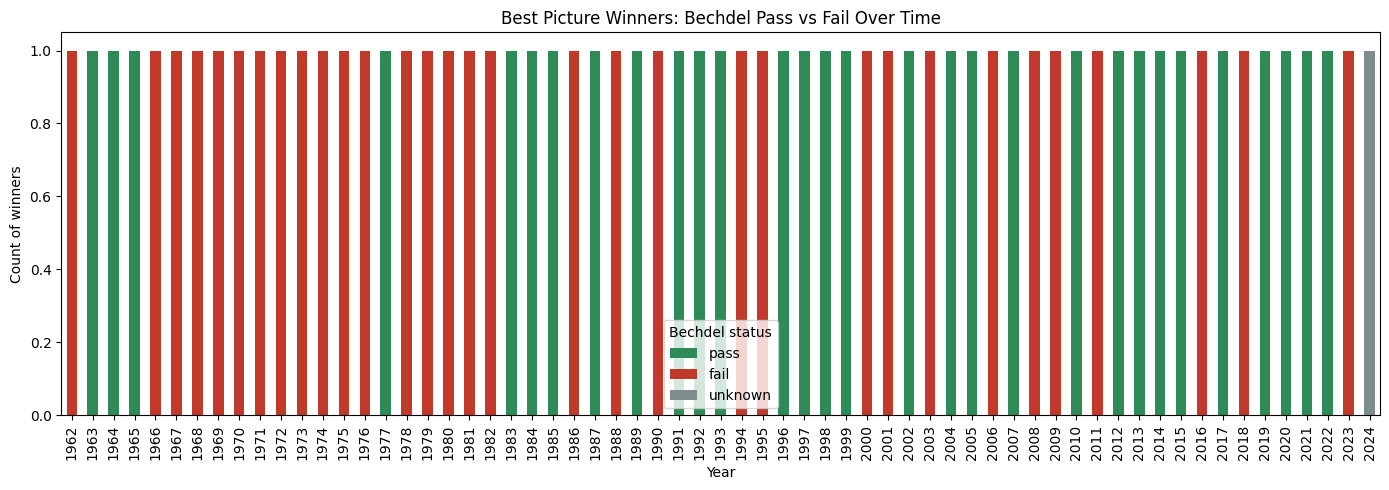

In [33]:
# Bar chart: Bechdel pass vs fail for Best Picture winners over time

if "winners_df" not in globals() or winners_df.empty:
    raise RuntimeError("Run the previous winners Bechdel cell first.")

import matplotlib.pyplot as plt

plot_df = winners_df.copy()
plot_df["status"] = plot_df["bechdel_pass"].map({True: "pass", False: "fail"}).fillna("unknown")

counts = (
    plot_df.groupby(["year", "status"]).size().unstack(fill_value=0)
    .reindex(columns=["pass", "fail", "unknown"], fill_value=0)
    .sort_index()
)

ax = counts.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 5),
    color={"pass": "#2e8b57", "fail": "#c0392b", "unknown": "#7f8c8d"},
)
ax.set_title("Best Picture Winners: Bechdel Pass vs Fail Over Time")
ax.set_xlabel("Year")
ax.set_ylabel("Count of winners")
ax.legend(title="Bechdel status")
plt.tight_layout()
plt.show()
